In [48]:


import os
import sys
import tensorflow as tf
import scipy.io.wavfile as wav
import glob
import numpy as np
import six
from six.moves import xrange as range
import json
from python_speech_features import mfcc
from sklearn.model_selection import train_test_split
import mlflow
import math
import os
from tensorflow.keras.layers import (BatchNormalization, Conv1D, Dense, Input,TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)
import librosa.display
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
from tensorflow.keras.callbacks import ModelCheckpoint 
sess = tf.compat.v1.Session(config=config)
import gc
 
import IPython.display as ipd
import soundfile

import random

import librosa

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


In [30]:
# tf.debugging.set_log_device_placement(True)

In [31]:
# Constants 
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = 1
FEAT_MASK_VALUE = 1e+10

# Some configs
num_features = 13
num_units = 100
num_classes = 285 + 1 # 285(including space) + blamk label = 286

# Hyper-parameters
num_epochs = 100
num_layers = 1
batch_size = 2
initial_learning_rate = 0.005
momentum = 0.9

In [36]:
# Loading the data
file_path = glob.glob('../data/train/wav/orginal*/*.wav')
file_path=file_path[1:200]
audio_list = []
fs_list = []
dur_list = []
dropped_file_path = []

for file_name in file_path:
    audio,fs = librosa.load(file_name,sr=16000)
    dur = librosa.get_duration(audio,sr=16000)
    audio_list.append(audio)
    dur_list.append(dur)
    fs_list.append(fs)
        
print(audio_list)

In [37]:
# Create a dataset composed of data with variable lengths
inputs_list = []
for index in range(len(audio_list)):
    input_val = mfcc(audio_list[index], samplerate=fs_list[index])
    input_val = (input_val - np.mean(input_val)) / np.std(input_val)
    inputs_list.append(input_val)

# Transform in 3D Array
train_inputs = tf.ragged.constant([i for i in inputs_list], dtype=np.float32)
train_seq_len = tf.cast(train_inputs.row_lengths(), tf.int32)
train_inputs = train_inputs.to_tensor(default_value=FEAT_MASK_VALUE)

In [38]:
with open('../data/train1.json', 'r', encoding='UTF-8') as label_file:
    labels = json.load(label_file)
with open('../data/language_model.json', 'r', encoding='UTF-8') as language_file:
    alphabets = json.load(language_file)


In [41]:
# Reading Targets
original_list = []
targets_list = []

for path in file_path:
    file_name = path[:-4].split('wav')[1][9:]
    # Read Label
    label = labels[file_name]
    original = " ".join(label.strip().split(' '))
    original_list.append(original)
    # print(original)
    target = original.replace(' ', '  ')
    # print('step-1. ',target)
    target = target.split(' ')
    # print('step-2. ', target)
    # Adding blank label
    target = np.hstack([SPACE_TOKEN if x == '' else list(x) for x in target])
    # print('step-3. ', target)
    # Transform char into index
    target = np.asarray([alphabets['char_to_num'][x] for x in target])
    # print('step-4. ', target)
    targets_list.append(target)


In [42]:
# Creating sparse representation to feed the placeholder
train_targets = tf.ragged.constant([i for i in targets_list], dtype=np.int32)
train_targets_len = tf.cast(train_targets.row_lengths(), tf.int32)
train_targets = train_targets.to_sparse()

In [43]:
train_targets.shape

TensorShape([199, 163])

In [44]:
# Split Training and Validation sets
# train_inputs, val_inputs = train_inputs[:800], train_inputs[800:]
# train_seq_len, val_seq_len = train_seq_len[:800], train_seq_len[800:]
# train_targets, val_targets = tf.sparse.slice(train_targets, start=[0, 0], size=[800, 163]), tf.sparse.slice(train_targets, start=[800, 0], size=[200, 163])
# train_targets_len, val_targets_len = train_targets_len[:800], train_targets_len[800:]

# train_inputs, val_inputs = train_inputs[:5], train_inputs[5:]
# train_seq_len, val_seq_len = train_seq_len[:5], train_seq_len[5:]
# train_targets, val_targets = tf.sparse.slice(train_targets, start=[0, 0], size=[
#                                              5, 73]), tf.sparse.slice(train_targets, start=[5, 0], size=[5, 73])
# train_targets_len, val_targets_len = train_targets_len[:5], train_targets_len[5:]

val_inputs, val_targets, val_seq_len, val_targets_len = train_inputs, train_targets, train_seq_len, train_targets_len


In [45]:
class CTCLossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        labels = inputs[0]
        logits = inputs[1]
        label_len = inputs[2]
        logit_len = inputs[3]

        logits_trans = tf.transpose(logits, (1,0,2))
        label_len = tf.reshape(label_len, (-1,))
        logit_len = tf.reshape(logit_len, (-1,))
        loss = tf.reduce_mean(tf.nn.ctc_loss(labels, logits_trans, label_len, logit_len, blank_index=-1))
        # define loss here instead of in compile
        self.add_loss(loss)

        # Decode
        decoded, _ = tf.nn.ctc_greedy_decoder(logits_trans, logit_len)

        # Inaccuracy: label error rate
        ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),labels))
        self.add_metric(ler, name='ler', aggregation='mean')

        return logits


In [46]:
# Defining Training Cells
cells = []
for _ in range(num_layers):
    cell = tf.keras.layers.LSTMCell(num_units)
    cells.append(cell)

stack = tf.keras.layers.StackedRNNCells(cells)

In [49]:
# Definning Input Parameters
input_feature = tf.keras.layers.Input((None, num_features), name='input_feature')
input_label = tf.keras.layers.Input((None,), dtype=tf.int32, sparse=True, name='input_label')
input_feature_len = tf.keras.layers.Input((1,), dtype=tf.int32, name='input_feature_len')
input_label_len =tf.keras.layers.Input((1,), dtype=tf.int32, name='input_label_len')

input_masking = tf.keras.layers.Masking(FEAT_MASK_VALUE)(input_feature)
x = tf.keras.layers.LSTM(100,return_sequences=True)(input_masking)
x_1 = tf.keras.layers.BatchNormalization()(x)
x_2 = tf.keras.layers.LSTM(100,return_sequences=True)(x_1)
x_3= tf.keras.layers.BatchNormalization()(x_2)
x_4 = tf.keras.layers.LSTM(100,return_sequences=True)(x_3)
# x = tf.keras.layers.BatchNormalization()(x)
# layer_rnn = tf.keras.layers.LSTM(10, return_sequences=True)(layer_bn)
# x = tf.keras.layers.Dropout(0.2, seed=42)(x)
layer_output = tf.keras.layers.TimeDistributed(Dense(num_classes, kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0,0.1), bias_initializer='zeros', name='logit'))(x_4)

layer_loss = CTCLossLayer()([input_label, layer_output, input_label_len, input_feature_len])


In [50]:
# Create models for training and prediction
model_train = tf.keras.models.Model(inputs=[input_feature, input_label, input_feature_len, input_label_len],
            outputs=layer_loss)
print(model_train.summary())
model_predict = tf.keras.models.Model(inputs=input_feature, outputs=layer_output)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_feature (InputLayer)      [(None, None, 13)]   0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, None, 13)     0           input_feature[0][0]              
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, None, 100)    45600       masking_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, None, 100)    400         lstm_3[0][0]                     
______________________________________________________________________________________________

In [51]:
# Compile Training Model with selected optimizer
optimizer = tf.keras.optimizers.Adam(initial_learning_rate, momentum)
model_train.compile(optimizer=optimizer)
checkpointer = ModelCheckpoint(filepath='../models/'+"RNN"+'.h5',monitor='val_loss',verbose=1, save_best_only=True, mode='min')
# Training, Our y is already defined so no need
# try:
#     experiment_id = mlflow.create_experiment("Stacked RNN(LSTM): 50 Cells")
#     experiment = mlflow.get_experiment(experiment_id)
# except mlflow.exceptions.MlflowException:
#     experiment = mlflow.get_experiment_by_name("Stacked RNN(LSTM): 50 Cells")

#mlflow.tensorflow.autolog()
history=model_train.fit(x=[train_inputs, train_targets, train_seq_len, train_targets_len], y=None,validation_data=([val_inputs, val_targets, val_seq_len, val_targets_len], None),batch_size=batch_size, epochs=num_epochs)


NameError: name 'ModelCheckpoint' is not defined

In [31]:
# Decoding
print('Original:')
print(original_list[0])
print(original_list[1])
print(original_list[2])
print(original_list[3])
print('Decoded:')


# train_inputs = tf.ragged.constant([i for i in inputs_list[:6]], dtype=np.float32)
# train_seq_len = tf.cast(train_inputs.row_lengths(), tf.int32)
# train_inputs = train_inputs.to_tensor(default_value=FEAT_MASK_VALUE)

decoded, _ = tf.nn.ctc_greedy_decoder(tf.transpose(
    model_predict.predict(train_inputs), (1, 0, 2)), train_seq_len)

d = tf.sparse.to_dense(decoded[0], default_value=-1).numpy()
str_decoded = [''.join([alphabets['num_to_char'][str(x)]
                       for x in np.asarray(row) if x != -1]) for row in d]

# print('decoded',str_decoded)
for s in str_decoded:
    # Replacing blank label to none
    # s = s.replace(chr(ord('z') + 1), '')
    # Replacing space label to space
    s = s.replace(alphabets['num_to_char']['0'], ' ')
    print(s)


Original:
ጓደኛ ዪቱ ብ ዪ ተ ብላ ብት ለመ ንም እሺ አ ላለች
አንበሳ ስጋ ስላ የ አጉረመረ መ
ዘነበ ች ሰራተኛዋ ን አታ ን ጓጉ ብላ ተቆጣ ቻት
ሸክላ ሰሪዋ አ ለሚ ቱ በ ጉልቻ ስራዋ የታወቀች ነች
Decoded:
በደኛዪቱ  ዪ ተላትመሺሺላ
በደሰሳ ስጋ ላ አራ
በመና ሰራተ  ብተቆ 
በላተሰሪለሚቱበጉለቻ ራታ ነች
በ  ኰ  መቱ  ያሰ ቃያተደ
በዱ በፔና  ተቴነ
በሚቴ ቃ ና ችሎለኮሚሺ ነ መላማሳ ካ
በለጠች ደ ኩ ጅ ነች
በታማደ ቃ ሴበሰገና ነጻ የተሳ ፎሁጀ
በሹ ቴተነ ደኦቶዶክ ተሼ አለላስክነ ሲሰከቶዶደ ተጣሚነ ደ በሹ ሚገናደላ
በዘጋጁ ፓቲላ ሁብመጠ በራነበ
በበሳ ዛጋስላ አሮረ
በ አቋቂ ተቋገ ሽ
በጲቆቱቷትላተና ተሰ  ነ 
በቋላ ዳጤ ሎተሪደረ
በጲንዳሚተራግኰኮደ ዛቸው ኢዮጵያንዲለእጠቃለሲሉ 
በሪ ካጥከሚቂኙ አ ገሮ   ሲ ገዛቀር ሷ ራሷገዢ ታበለዛዘኞቹ ተፈርደለ
በጀጐዳሰ ዬነጻ አች
በላበለጅነቱ ቆ በ
በ የጀመረዚስጀቲናጥለቱዲን በጫ
በድ ተሿችግማት 
በ   ጉረሚጂ ት ሀጣገዛ  አ
በደሎ ጋትጠሽ ኢትዮጵን በቸጋሪ ጐነ
በደ ዛለ ጬ  ለራድ ኮራ ሁበደበቱ ጬየተስደበና  ንቆጬስቱሰቃ የ በጊዜ ፎዲ  መጬናጐበጬጄሳ አጬ በ ቆናደ 
በተከከ ተ ኬ ሮላተሰኢ ዮጵንሞተ
በትዮጵ ክና ተቃ በለ በታ ታ
በቁጅናመደ መድነ
በፖለቲካተተታዳ ዮጲያደ ፊትተራ ትሩመላ
በለሳቸት ቴተባለነገለ
በክላሰቱ በጐራታቀች ነ
በመቱ ደኛዜዪቱ  ስታር ሳ ተ
በበረኩት 
በቁ  ሻ  ተ ስገለፖሶቹ  ደጣቀበ ተረ ገላቸው
በራተርቀሞ ስለደዘራራ ለጐመራ
በተፈራ ተቀስለ ተራቶ ጐራ
በሴቶ ቶ ደ ቷስሚሜዳበመለ ሚበረተታ
በዮጵያክን ተቀበለቸው  በዛ ስ ተ
በሮፓዲሲፕደየሜደቻ  በተ
በረታቸው ደዙደመሰቸው 
በሩእዲ ህበና ንኳ ሽ አ በ
በቻችጐተ ስለላደት  ሰ ድሰ
በ ና ተዚዳ ኢትዮጵተራደድበሉገቸው  በ ሰላዲ ቱ ታሪማ

In [18]:
alphabets['num_to_char']['0']

'<space>'

In [16]:
y,sr= librosa.load('../data/train/wav/tr_10_tr01010#bn00.wav',sr=16000)

def plot_raw_audio(y, title='Audio Signal', size=(12, 3)):
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)
    steps = len(y)
    ax.plot(np.linspace(1, steps, steps), y)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()



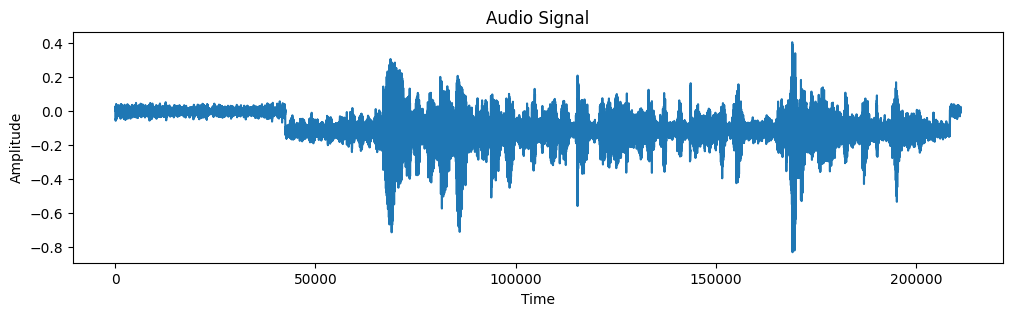

In [17]:
plot_raw_audio(vis_raw_audio)


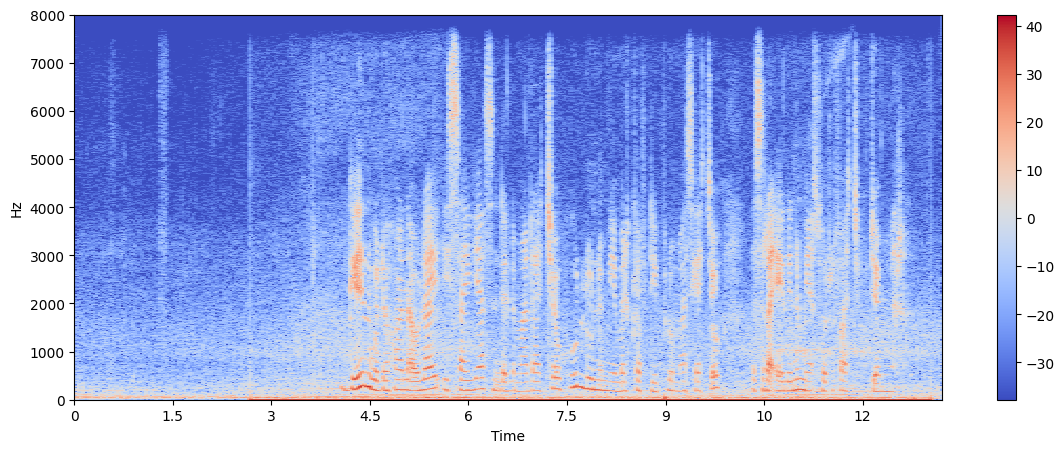

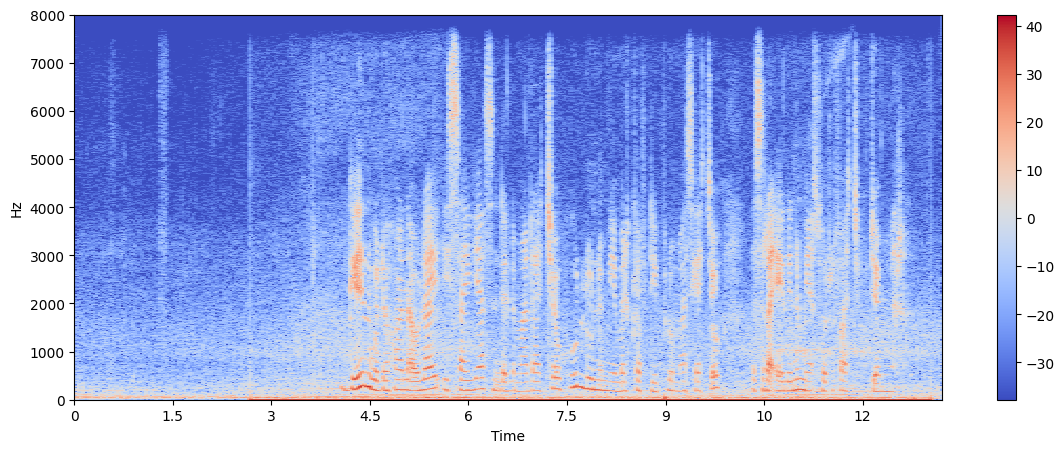

In [19]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

In [20]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
def plot_mfcc_feature(vis_mfcc_feature):
    # plot the MFCC feature
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_mfcc_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()

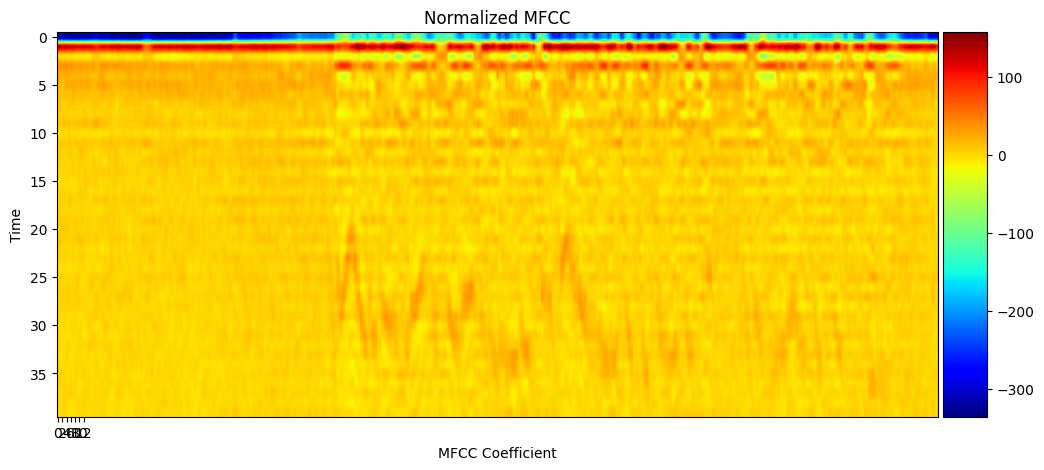

In [21]:
plot_mfcc_feature(mfccs)

In [15]:

def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
import pickle
import matplotlib.pyplot as plt

def plot_hist(p):
    hist = pickle.load(open( "models/" + p + ".pickle", "rb"))
    plt.plot(hist['loss'], label="train")
    plt.plot(hist['val_loss'], label="valid")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show